IT5437 – Assignment 1 

In [1]:
# === Setup: installs & imports ===
!pip -q install opencv-python-headless==4.10.0.84


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.figsize'] = (6,4)

def load_image(path):
    """Load an image from path (returns BGR)."""
    img = cv.imread(str(path), cv.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    return img

def show(img, title=None, cmap=None):
    plt.figure()
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or 'gray')
    else:
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

def plot_hist(img, title="Histogram", color=True):
    plt.figure()
    if img.ndim == 2:
        plt.hist(img.ravel(), bins=256, range=(0,255))
    else:
        if color:
            for i, col in enumerate(("b","g","r")):
                plt.hist(img[:,:,i].ravel(), bins=256, range=(0,255), alpha=0.5, label=col)
            plt.legend()
        else:
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            plt.hist(gray.ravel(), bins=256, range=(0,255))
    plt.title(title)
    plt.show()

def to_uint8(x):
    return np.clip(np.round(x), 0, 255).astype(np.uint8)

Q1. Intensity transformation (apply Fig. 1a to Fig. 1b)
Define the curve by control points and apply via LUT.

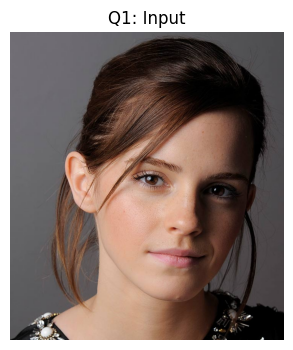

In [5]:
# Q1 – Intensity Transformation
img = load_image(r"emma.jpg")
show(img, "Q1: Input")

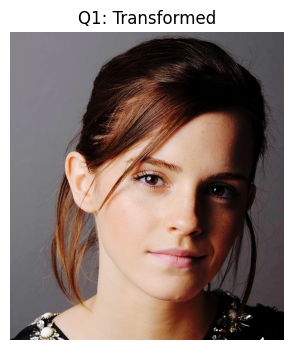

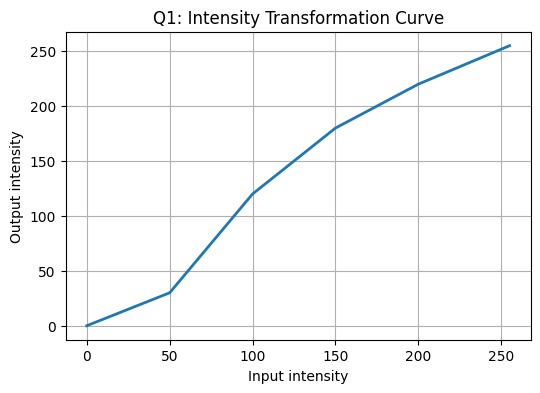

In [6]:
# Define control points (adjust to match Fig. 1a)
control_x = np.array([0, 50, 100, 150, 200, 255], dtype=np.float32)
control_y = np.array([0, 30, 120, 180, 220, 255], dtype=np.float32)

x = np.arange(256, dtype=np.float32)
lut = np.interp(x, control_x, control_y)
lut_u8 = to_uint8(lut)

out = cv.LUT(img, lut_u8)
show(out, "Q1: Transformed")

plt.figure()
plt.plot(x, lut, lw=2)
plt.title("Q1: Intensity Transformation Curve")
plt.xlabel("Input intensity")
plt.ylabel("Output intensity")
plt.grid(True)
plt.show()

Q2. Accentuate white & gray matter (Fig. 2)
Use separate LUTs to emphasize high (white matter) and mid (gray matter) intensities.

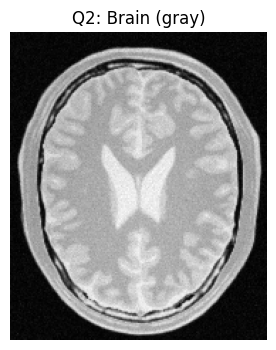

In [7]:
# Q2 – Brain proton density image (Fig. 2)
brain = load_image("brain_proton_density_slice.png")  
# Convert to grayscale if image is RGB
if brain.ndim == 3:
    brain_gray = cv.cvtColor(brain, cv.COLOR_BGR2GRAY)
else:
    brain_gray = brain.copy()

# Show result
show(brain_gray, "Q2: Brain (gray)")


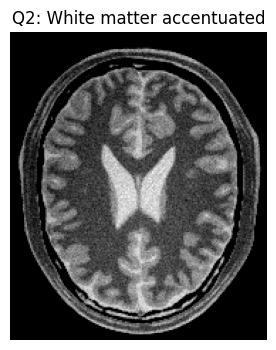

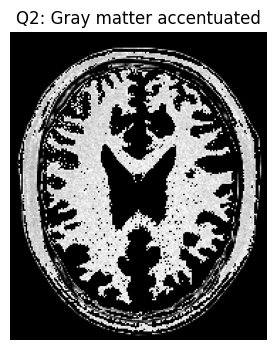

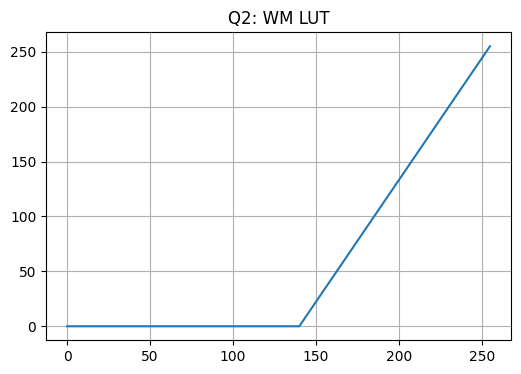

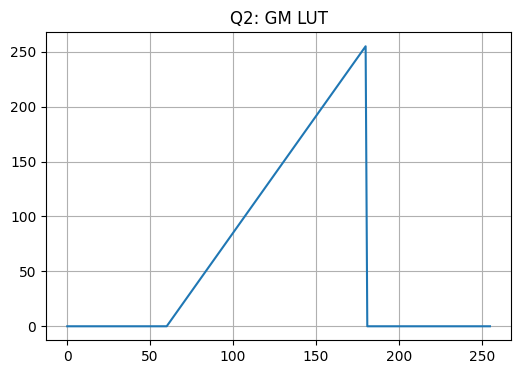

In [8]:
wm_low, wm_high = 140, 255
x = np.arange(256, dtype=np.float32)
wm_lut = np.piecewise(x,
    [x<wm_low, (x>=wm_low)&(x<=wm_high), x>wm_high],
    [0, lambda t: 255*(t-wm_low)/(wm_high-wm_low+1e-6), 255])
wm = cv.LUT(brain_gray, to_uint8(wm_lut))

gm_c, gm_w = 120, 60
gm_low, gm_high = gm_c-gm_w, gm_c+gm_w
gm_lut = np.piecewise(x,
    [x<gm_low, (x>=gm_low)&(x<=gm_high), x>gm_high],
    [0, lambda t: 255*(t-gm_low)/(gm_high-gm_low+1e-6), 0])
gm = cv.LUT(brain_gray, to_uint8(gm_lut))

show(wm, "Q2: White matter accentuated")
show(gm, "Q2: Gray matter accentuated")
plt.figure(); plt.plot(x, wm_lut); plt.title("Q2: WM LUT"); plt.grid(True); plt.show()
plt.figure(); plt.plot(x, gm_lut); plt.title("Q2: GM LUT"); plt.grid(True); plt.show()


Q3. Gamma correction on L* in Lab (Fig. 3)
Apply gamma to L, then show histograms before/after.

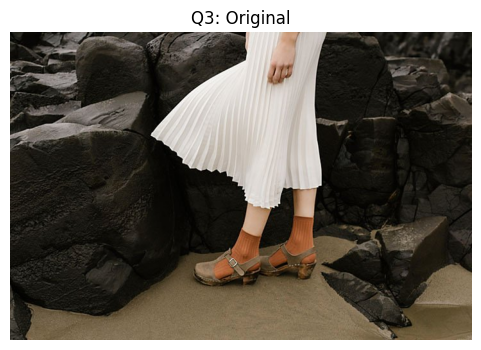

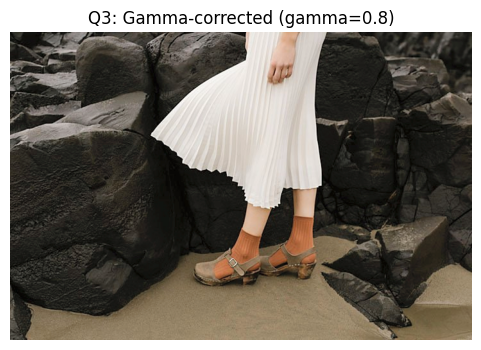

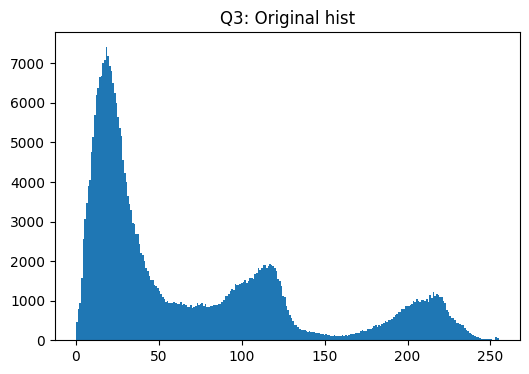

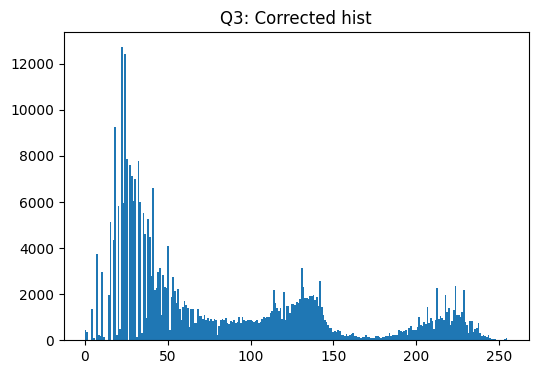

In [9]:
# Q3 – Gamma correction on L* in Lab space
img3 = load_image("highlights_and_shadows.jpg")

# Convert to Lab
lab = cv.cvtColor(img3, cv.COLOR_BGR2LAB)
L, A, B = cv.split(lab)

# Apply gamma correction to L
gamma = 0.8  # adjust & report
Ln = L.astype(np.float32) / 255.0
Lcorr = to_uint8((Ln ** gamma) * 255.0)

# Recombine channels
out3 = cv.cvtColor(cv.merge([Lcorr, A, B]), cv.COLOR_LAB2BGR)

# Show results
show(img3, "Q3: Original")
show(out3, f"Q3: Gamma-corrected (gamma={gamma})")

# Show histograms
plot_hist(cv.cvtColor(img3, cv.COLOR_BGR2GRAY), "Q3: Original hist", color=False)
plot_hist(cv.cvtColor(out3, cv.COLOR_BGR2GRAY), "Q3: Corrected hist", color=False)

Q4. Vibrance via saturation transform (Fig. 4)
f(x) = min(x + a * 128 * exp(-(x-128)^2/(2*sigma^2)), 255), sigma=70

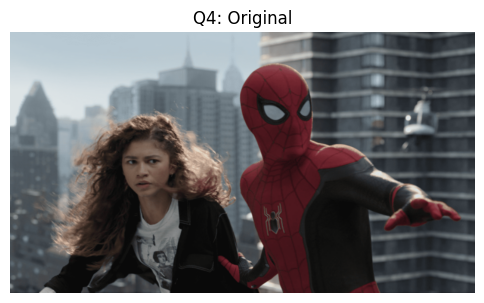

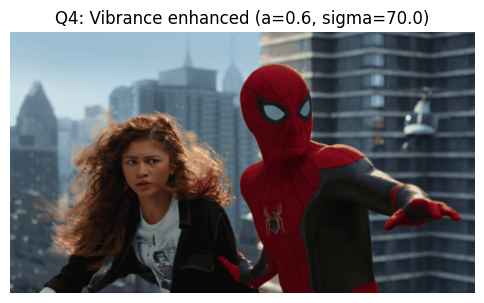

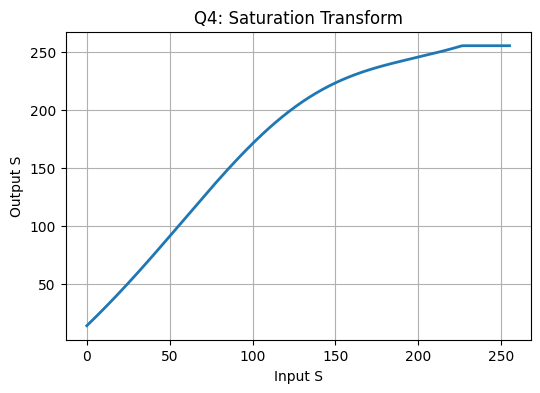

In [10]:
# Q4 – Vibrance enhancement (apply to saturation channel)
img4 = load_image("spider.png") 

# Convert to HSV
hsv = cv.cvtColor(img4, cv.COLOR_BGR2HSV)
H, S, V = cv.split(hsv)

# Define transformation parameters
sigma = 70.0
a = 0.6  # adjust & report
x = np.arange(256, dtype=np.float32)

# Compute vibrance LUT
bump = a * 128.0 * np.exp(-((x - 128.0) ** 2) / (2 * sigma ** 2))
lut = np.minimum(x + bump, 255.0)

# Apply LUT to saturation channel
S2 = cv.LUT(S, to_uint8(lut))

# Recombine HSV → BGR
out4 = cv.cvtColor(cv.merge([H, S2, V]), cv.COLOR_HSV2BGR)

# Show results
show(img4, "Q4: Original")
show(out4, f"Q4: Vibrance enhanced (a={a}, sigma={sigma})")

# Plot the intensity transformation
plt.figure()
plt.plot(x, lut, lw=2)
plt.title("Q4: Saturation Transform")
plt.xlabel("Input S")
plt.ylabel("Output S")
plt.grid(True)
plt.show()

Q5. Foreground-only histogram equalization (Fig. 5)
Threshold (V via Otsu), equalize only foreground using cumsum, recombine.

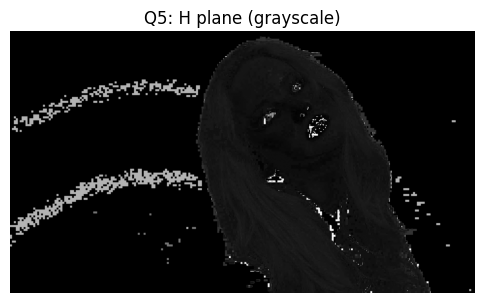

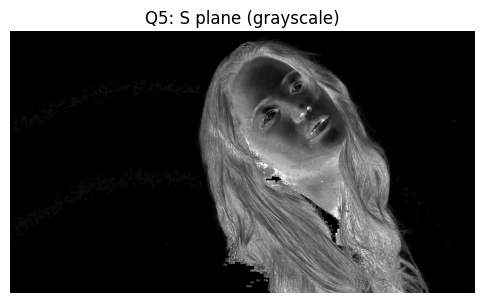

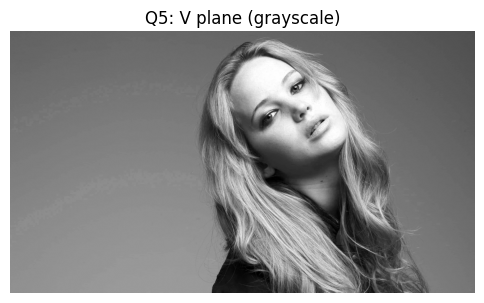

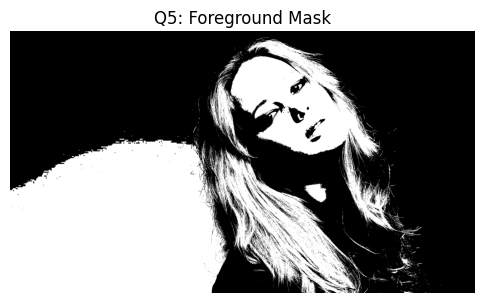

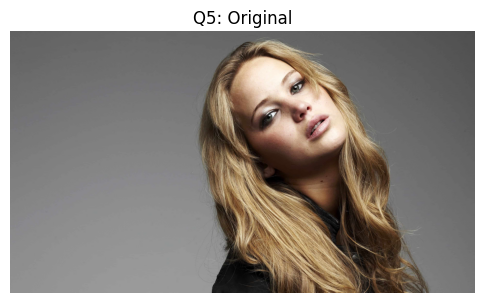

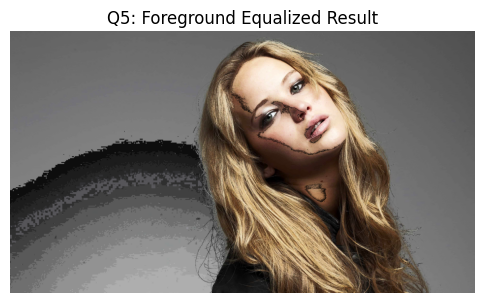

In [11]:
# Q5 – Foreground-only histogram equalization
img5 = load_image("jeniffer.jpg")  

# Convert to HSV
hsv5 = cv.cvtColor(img5, cv.COLOR_BGR2HSV)
H, S, V = cv.split(hsv5)

# Show planes
show(H, "Q5: H plane (grayscale)")
show(S, "Q5: S plane (grayscale)")
show(V, "Q5: V plane (grayscale)")

# Threshold V using Otsu to get mask
_, mask = cv.threshold(V, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
show(mask, "Q5: Foreground Mask")

# Foreground-only histogram equalization
fg = cv.bitwise_and(V, V, mask=mask)
hist = cv.calcHist([fg], [0], mask, [256], [0,256]).ravel()
cdf = np.cumsum(hist)
cdf_norm = (cdf - cdf.min()) / (cdf.max() - cdf.min() + 1e-6) * 255.0
lut = to_uint8(cdf_norm)

V_eq = V.copy()
V_eq[mask > 0] = lut[V[mask > 0]]

# Recombine HSV → BGR
out5 = cv.cvtColor(cv.merge([H, S, V_eq]), cv.COLOR_HSV2BGR)

# Show results
show(img5, "Q5: Original")
show(out5, "Q5: Foreground Equalized Result")

Q6. Sobel filtering (filter2D, manual, separable) on Fig. 6

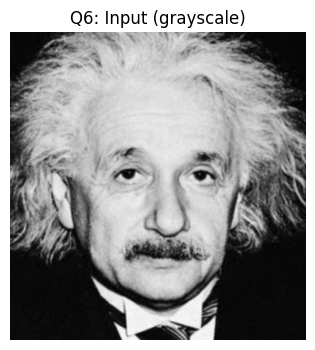

In [ ]:
# Q6 – Sobel filtering (Input image)
img6 = load_image("einstein.png") 
# Convert to grayscale
gray6 = cv.cvtColor(img6, cv.COLOR_BGR2GRAY)

# Show result
show(gray6, "Q6: Input (grayscale)")

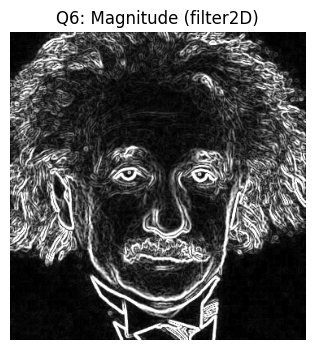

In [13]:
Kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]], np.float32)
Ky = Kx.T
Gx = cv.filter2D(gray6, cv.CV_32F, Kx)
Gy = cv.filter2D(gray6, cv.CV_32F, Ky)
mag1 = cv.magnitude(Gx, Gy)
show(to_uint8(mag1), "Q6: Magnitude (filter2D)")

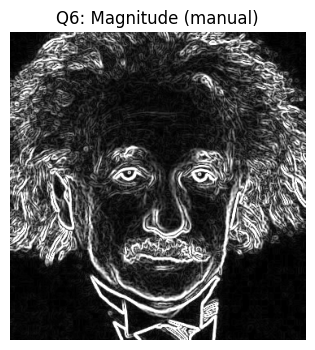

In [14]:
def conv2(img, kernel):
    kh, kw = kernel.shape
    pad_h, pad_w = kh//2, kw//2
    padded = cv.copyMakeBorder(img, pad_h, pad_h, pad_w, pad_w, cv.BORDER_REFLECT)
    out = np.zeros_like(img, dtype=np.float32)
    k = np.flipud(np.fliplr(kernel))
    for y in range(out.shape[0]):
        for x in range(out.shape[1]):
            out[y,x] = np.sum(padded[y:y+kh, x:x+kw] * k)
    return out

Gx2 = conv2(gray6.astype(np.float32), Kx)
Gy2 = conv2(gray6.astype(np.float32), Ky)
mag2 = cv.magnitude(Gx2, Gy2)
show(to_uint8(mag2), "Q6: Magnitude (manual)")

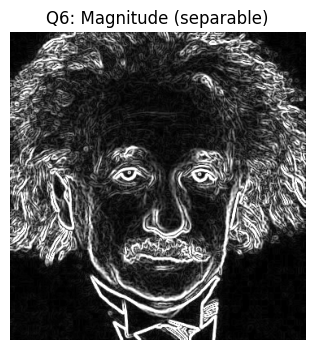

In [15]:
v = np.array([[1],[2],[1]], np.float32)
h = np.array([[1,0,-1]], np.float32)
Gx3 = cv.filter2D(cv.filter2D(gray6, cv.CV_32F, v), cv.CV_32F, h)
Gy3 = cv.filter2D(cv.filter2D(gray6, cv.CV_32F, h.T), cv.CV_32F, v.T)
mag3 = cv.magnitude(Gx3, Gy3)
show(to_uint8(mag3), "Q6: Magnitude (separable)")

Q7. Image zooming (nearest & bilinear) + NSSD vs original

NSSD (nearest):  0.012057949
NSSD (bilinear): 0.010184055


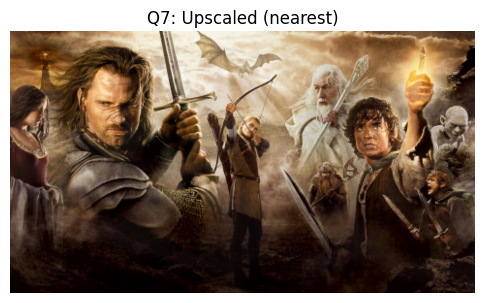

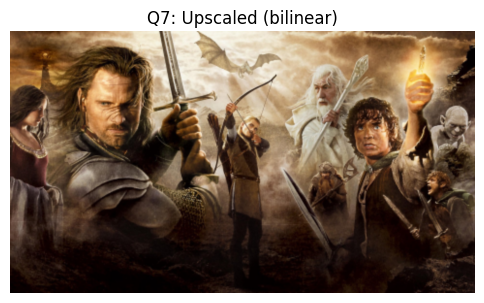

In [17]:
# Q7 – Image zooming (nearest & bilinear) + NSSD comparison

# Load images 
small = load_image(r"a1q8images/im01small.png")  
orig  = load_image(r"a1q8images/im01.png")    

s = 4.0  # scale factor

# Zoom function
def zoom(img, s, method='nearest'):
    h, w = img.shape[:2]
    new_size = (int(w*s), int(h*s))
    interp = cv.INTER_NEAREST if method == 'nearest' else cv.INTER_LINEAR
    return cv.resize(img, new_size, interpolation=interp)

# Upscale with both methods
up_nearest = zoom(small, s, 'nearest')
up_bilinear = zoom(small, s, 'bilinear')

# Crop to common size for comparison
H = min(orig.shape[0], up_bilinear.shape[0])
W = min(orig.shape[1], up_bilinear.shape[1])
A  = orig[:H, :W]
Bn = up_nearest[:H, :W]
Bl = up_bilinear[:H, :W]

# Normalized Sum of Squared Differences (NSSD)
def nssd(a, b):
    a32 = a.astype(np.float32)
    b32 = b.astype(np.float32)
    return np.mean((a32 - b32) ** 2) / (np.mean(a32 ** 2) + 1e-8)

print("NSSD (nearest): ", nssd(A, Bn))
print("NSSD (bilinear):", nssd(A, Bl))

# Show results
show(up_nearest, "Q7: Upscaled (nearest)")
show(up_bilinear, "Q7: Upscaled (bilinear)")

Q8. GrabCut segmentation & background blur (Fig. 7)

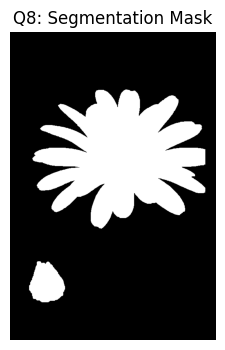

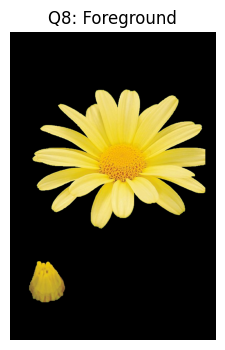

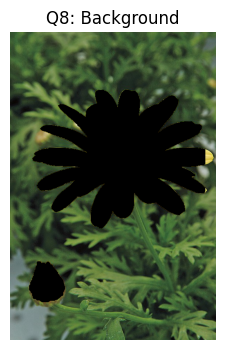

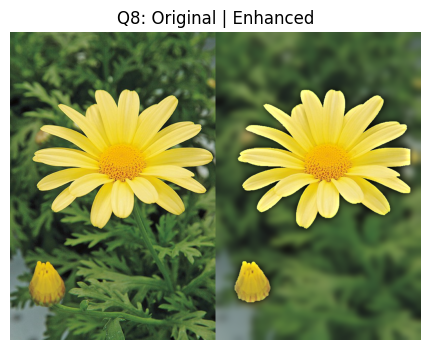

In [ ]:
# Q8 – GrabCut segmentation + background blur

# Load image
img8 = load_image("daisy.jpg")

# Define initial rectangle (slightly inside the full image)
h, w = img8.shape[:2]
rect = (int(0.05 * w), int(0.05 * h), int(0.9 * w), int(0.9 * h))

# Initialize mask and models
mask = np.zeros((h, w), np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Apply GrabCut
cv.grabCut(img8, mask, rect, bgdModel, fgdModel, 5, cv.GC_INIT_WITH_RECT)
mask2 = np.where((mask == cv.GC_FGD) | (mask == cv.GC_PR_FGD), 255, 0).astype('uint8')

# Extract foreground and background
fg = cv.bitwise_and(img8, img8, mask=mask2)
bg_mask = cv.bitwise_not(mask2)
bg = cv.bitwise_and(img8, img8, mask=bg_mask)

# Blur background
bg_blur = cv.GaussianBlur(bg, (0, 0), 9)

# Combine foreground with blurred background
enhanced = cv.add(fg, bg_blur)

# Show results
show(mask2, "Q8: Segmentation Mask")
show(fg, "Q8: Foreground")
show(bg, "Q8: Background")
show(np.hstack([img8, enhanced]), "Q8: Original | Enhanced")

Q8(c) Answer: The dark halo just beyond the flower edge is due to imperfect GrabCut boundaries and hard compositing: ambiguous edge pixels are assigned to background, then blurred and recombined, creating a darker rim where background adjoins the foreground.

Q9. Rice grain counting (Fig. 8a, 8b)

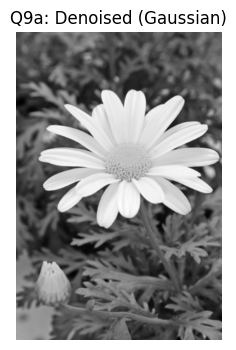

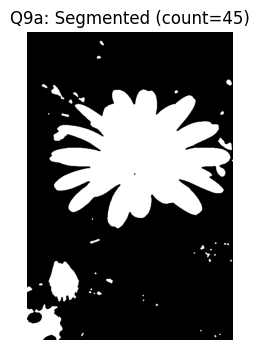

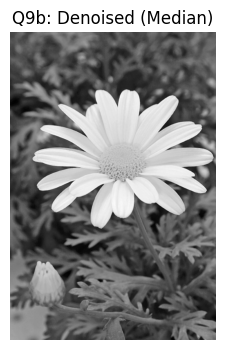

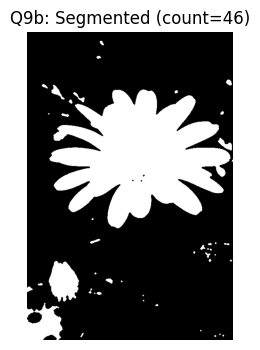

Q9a grains (approx): 45
Q9b grains (approx): 46


In [25]:
img9a= load_image("daisy.jpg")
img9b= load_image("daisy.jpg")

ga = cv.cvtColor(img9a, cv.COLOR_BGR2GRAY)
gb = cv.cvtColor(img9b, cv.COLOR_BGR2GRAY)

ga_dn = cv.GaussianBlur(ga, (5,5), 1.0)
gb_dn = cv.medianBlur(gb, 3)

_, ta = cv.threshold(ga_dn, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
_, tb = cv.threshold(gb_dn, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
ta_clean = cv.morphologyEx(ta, cv.MORPH_OPEN, kernel, iterations=2)
ta_clean = cv.morphologyEx(ta_clean, cv.MORPH_CLOSE, kernel, iterations=2)

tb_clean = cv.morphologyEx(tb, cv.MORPH_OPEN, kernel, iterations=2)
tb_clean = cv.morphologyEx(tb_clean, cv.MORPH_CLOSE, kernel, iterations=2)

cc_a, labels_a, stats_a, _ = cv.connectedComponentsWithStats(ta_clean, connectivity=8)
cc_b, labels_b, stats_b, _ = cv.connectedComponentsWithStats(tb_clean, connectivity=8)

count_a = stats_a.shape[0]-1
count_b = stats_b.shape[0]-1

show(ga_dn, "Q9a: Denoised (Gaussian)")
show(ta_clean, f"Q9a: Segmented (count={count_a})")
show(gb_dn, "Q9b: Denoised (Median)")
show(tb_clean, f"Q9b: Segmented (count={count_b})")

print("Q9a grains (approx):", count_a)
print("Q9b grains (approx):", count_b)

Q10. Sapphire areas (Fig. 9) with connected components and geometry

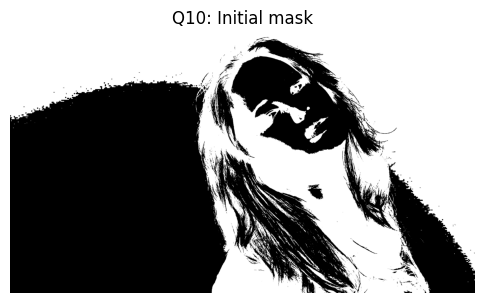

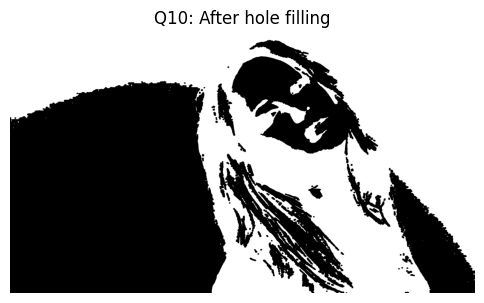

Pixel areas: [4164433, 12, 5, 16, 117, 84, 5, 8, 431, 5, 5, 12, 10, 5, 5, 8, 7654, 143, 80, 20, 23, 34, 20, 5, 18, 34, 20, 14, 133, 529, 86, 5, 54, 19, 5, 8, 5, 60, 15439, 14, 34, 70, 20, 23, 20, 101, 11, 67, 8, 5, 5, 14, 82, 11541, 49, 24, 20, 114, 214, 28, 20427, 8, 5, 36, 20, 16, 19, 19, 17, 5, 5, 28, 5, 5, 16, 5, 276, 5, 5, 20, 15, 457, 5, 8, 5057, 5, 24, 5, 32, 11, 80, 128, 45, 76, 15, 23, 8, 19, 14, 11, 94, 170, 250, 28, 3657, 8, 930, 70, 5, 8, 11, 93, 5, 11, 33, 8, 5, 471, 125, 29, 21, 56, 5, 68, 20, 5, 103, 505, 32, 238, 991, 182, 13, 205, 5, 13, 38, 5, 5, 59, 5, 42, 44, 33, 20, 195, 5, 20, 13, 13, 2185, 144, 5, 727, 14, 37, 8, 8, 5, 20, 8, 74, 34, 205, 20, 8, 8, 41, 5, 37, 28, 8, 119, 100, 5, 5, 10, 5, 152, 56, 12, 5, 88, 68, 5, 5, 40, 14, 96]
Object 1: area_pixels=4164433, area_mm2≈374798.97 (pixel_pitch=5.0 µm)
Object 2: area_pixels=12, area_mm2≈1.08 (pixel_pitch=5.0 µm)
Object 3: area_pixels=5, area_mm2≈0.45 (pixel_pitch=5.0 µm)
Object 4: area_pixels=16, area_mm2≈1.44 (pixe

In [27]:
img10= load_image("jeniffer.jpg")
gray10 = cv.cvtColor(img10, cv.COLOR_BGR2GRAY)

g = cv.GaussianBlur(gray10, (5,5), 0)
_, th = cv.threshold(g, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

# Ensure sapphires are white in mask
if np.mean(g[th>0]) < np.mean(g[th==0]):
    mask = th
else:
    mask = cv.bitwise_not(th)

mask_filled = cv.morphologyEx(mask, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5)), iterations=3)
mask_filled = cv.morphologyEx(mask_filled, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)), iterations=1)

num, labels, stats, centroids = cv.connectedComponentsWithStats(mask_filled, connectivity=8)
areas_px = stats[1:, cv.CC_STAT_AREA]

show(mask, "Q10: Initial mask")
show(mask_filled, "Q10: After hole filling")
print("Pixel areas:", areas_px.tolist())

# Real-world conversion parameters
f_mm = 8.0
Z_mm = 480.0
pixel_pitch_mm = 0.005  # 5 µm; set to your camera

s_mm = (Z_mm / f_mm) * pixel_pitch_mm
area_per_pixel_mm2 = s_mm**2
areas_mm2 = areas_px * area_per_pixel_mm2

for i, (apx, amm2) in enumerate(zip(areas_px, areas_mm2), start=1):
    print(f"Object {i}: area_pixels={int(apx)}, area_mm2≈{amm2:.2f} (pixel_pitch={pixel_pitch_mm*1000:.1f} µm)")
